In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [2]:
data = pd.read_hdf("data.h5", 'df')
# data = pd.read_csv("data.csv")
train_df, test_df = train_test_split(data, test_size=0.5)
test_df, CV_df = train_test_split(test_df, test_size=0.5)

In [3]:
print(data)

         id                                                  X  \
0     p0_66  [70, 100, 115, 130, 145, 160, 175, 190, 205, 2...   
1    p10_36  [70, 85, 100, 115, 130, 145, 160, 175, 190, 20...   
2    p11_70  [55, 70, 85, 100, 115, 130, 145, 160, 175, 205...   
3    p11_98  [55, 70, 85, 100, 130, 145, 160, 175, 190, 220...   
4    p11_99  [55, 85, 100, 115, 145, 160, 175, 190, 205, 22...   
..      ...                                                ...   
127   p97_3  [55, 70, 85, 100, 130, 145, 160, 175, 190, 205...   
128  p97_51  [55, 70, 85, 115, 130, 145, 160, 175, 190, 205...   
129  p97_90  [55, 85, 100, 115, 130, 145, 160, 175, 190, 22...   
131  p99_38  [55, 85, 100, 115, 145, 160, 175, 190, 205, 22...   
132   p9_37  [70, 85, 115, 130, 145, 160, 175, 205, 220, 23...   

                                                     Y   vertex  
0    [1847.96, 1125.22, 1636.88, 1500.98, 2160.9, 1...  148.572  
1    [807.613, 2694.69, 1501.35, 615.797, 967.48, 1...  141.616  
2    [635

In [12]:
class MyDataset(Dataset):
    def __init__(self, dataframe):

        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor(self.data.iloc[idx, 1:-1], dtype=torch.float32)
        features = features.t()
        target = torch.tensor(self.data.iloc[idx, -1], dtype=torch.float32)
        return features, target

In [13]:
batch_size = 1 # Adjust batch size as needed
# sequence_length = 3  # Adjust sequence length as needed
shuffle = True  # Shuffle the data during training (recommended)
dataS = MyDataset(data)
train = MyDataset(train_df)
test = MyDataset(test_df)
CVS = MyDataset(CV_df)
trainloader = DataLoader(train, batch_size=1, shuffle=shuffle)
testloader = DataLoader(test)
dataloader = DataLoader(dataS, batch_size=1, shuffle=shuffle)
CVloader = DataLoader(CVS)

In [14]:
for f, t, j in dataloader:
    print(j)

tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])
tensor([10])

In [6]:
class ManyToOneRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ManyToOneRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the RNN
        out, _ = self.rnn(x,h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [7]:
cost_list = []
CVcost_list = []
input_size = 2
hidden_size = 4
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 10000

model = ManyToOneRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
def train():
    model.train()

    for epoch in range(num_epochs):
        COST=0
        CVCost = 0
        i = 0
        for dat,target in trainloader:  # Iterate in batches over the training dataset.
            out = model(dat)  # Perform a single forward pass.
            loss = criterion(out, target)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            COST += loss.data
            i += 1
            # if epoch % 100 == 0 and i ==1 :
                # print("loss is {}".format(loss.data))
                # print("target value is {}".format(target))
                # print("out is {}".format(out))

        cost_list.append(COST)

        #perform a prediction on the validation  data
        for CVD,CVT in CVloader:

            with torch.no_grad():
               CVout = model(CVD)
            loss = criterion(CVout, CVT)

            CVCost += loss

        CVcost_list.append(CVCost)

        if epoch%500 == 0:
            print("epoch number:{}".format(epoch))
            print("validation MSE is {}".format(COST))
            print("train MSE is {}".format(CVCost))


In [9]:

tstart=time.time()
print("start time={}".format(tstart))
train()
torch.save(model, 'model.pth')

print((time.time()-tstart))

start time=1701114335.909887


/Users/tianqi/Work_Place/ANNIE/.conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch number:0
validation MSE is 4871443.0
train MSE is 1226322.375


KeyboardInterrupt: 

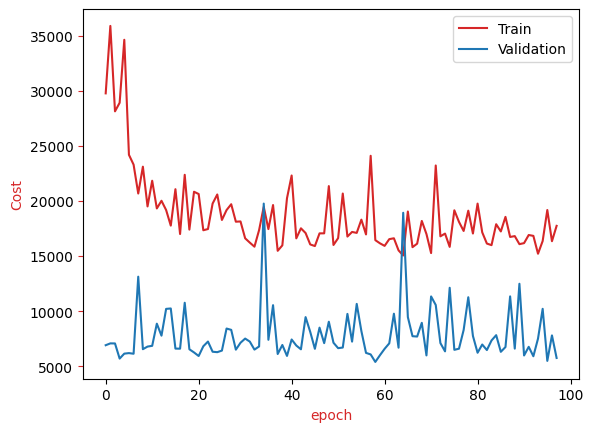

In [ ]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list[200::100], color=color,label="Train")
ax1.plot(CVcost_list[200::100], color='tab:blue',label="Validation")
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
ax1.legend()

In [ ]:
def test(loader):
     model.eval()

     diff_list = []
     for data,target in loader:  # Iterate in batches over the training/test dataset.
        with torch.no_grad():
            out = model(data)
            diff = out - target  # Use the class with highest probability.
            diff_list.append(diff.data.numpy()[0][0])  # Check against ground-truth labels.
            # diff_list.append(diff.data.numpy())  # Check against ground-truth labels.
     return diff_list  # Derive ratio of correct predictions.


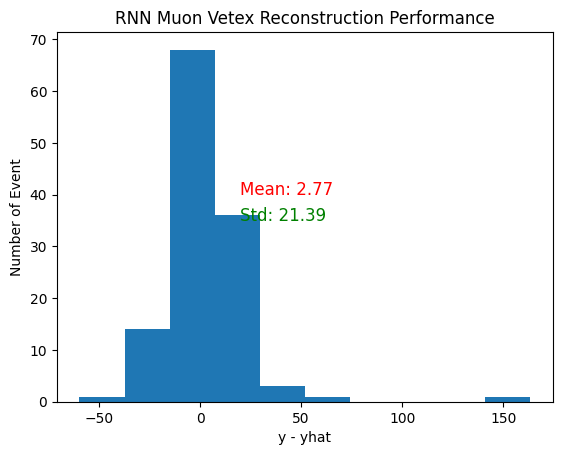

In [ ]:

diff_list = test(dataloader)



plt.hist(diff_list)

mean = np.mean(diff_list)
std = np.std(diff_list)

# custom_labels = ['Mean is {}'.format(mean), 'Std is {}'.format(std)]

# Add a legend with custom labels
plt.text(20, 40, f'Mean: {mean:.2f}', fontsize=12, color='red')
plt.text(20, 35, f'Std: {std:.2f}', fontsize=12, color='green')


plt.xlabel("y - yhat")
plt.ylabel("Number of Event")
plt.title("RNN Muon Vetex Reconstruction Performance")
# plt.legend(custom_labels)
plt.savefig("RNN.png")